数据建模流程：
1. 原始数据获取：原始数据字典、原始字段分析、清洗逻辑
2. 数据预处理：ETL加工、缺失值、异常值
3. 特征工程：指标体系构建、模型变量字典、衍生变量计算、入模变量重要性筛选
4. 模型训练：算法选择、交叉验证、参数调整
5. 模型评价与优化：模型结果比较、效果评估（AUC、KS）、模型解释
6. 模型上线：上线部署、接口联调

## 载入函数库

In [19]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_curve,auc
from sklearn.grid_search import GridSearchCV
import matplotlib.pyplot as plt
from xgboost.sklearn import XGBClassifier

## 自定义函数库

In [2]:
###生成原始数据
#n_points：数据个数，默认1000
def produce_data(n_points=1000):
    data = pd.DataFrame()
    #选定随机种子
    np.random.seed(0)
    #生成特征
    data['practice'] = np.random.random(n_points)
    data['time_period'] = np.random.random(n_points)
    #生成噪音
    data['error'] = np.random.random(n_points)
    #生成类别标签
    data['label'] = np.round(data['practice'] * data['time_period'] + 0.3 + 0.2 * data['error'])
    data['label'][data['practice'] > 0.8] = 1
    data['label'][data['time_period'] > 0.8] = 1
    return(data)

In [14]:
###测试集数据可视化
#clf：训练好的分类器
#X_test：测试数据特征
#Y_test：测试数据类别
def plot_pic(clf,X_test,Y_test):
    x_min = 0.0; x_max = 1.0
    y_min = 0.0; y_max = 1.0
    #画出决策边界，为每一个点绘制一个颜色
    step = .01
    xx, yy = np.meshgrid(np.arange(x_min, x_max, step), np.arange(y_min,y_max,step))
    Z = clf.predict(pd.DataFrame(np.c_[xx.ravel(), yy.ravel()],columns=['practice','time_period']))
    #绘图
    Z = Z.reshape(xx.shape)
    plt.xlim(xx.min(),xx.max())
    plt.ylim(yy.min(),yy.max())
    plt.pcolormesh(xx, yy, Z, cmap=plt.cm.RdYlBu)
    data = X_test.copy()
    data['label'] = Y_test
    practice_fail = data[data['label'] == 0]['practice']
    time_period_fail = data[data['label'] == 0]['time_period']
    practice_pass = data[data['label'] == 1]['practice']
    time_period_pass = data[data['label'] == 1]['time_period']
    plt.scatter(practice_fail, time_period_fail, color='b',label='fail')
    plt.scatter(practice_pass, time_period_pass, color='r',label='pass')
    plt.legend()
    plt.xlabel('practice')
    plt.ylabel('time_period')
    plt.legend(loc='upper right')
    plt.show()

In [4]:
###计算模型准确性AUC
#data：测试数据
#score_col：测试数据预测值
#class_col：测试数据实际类别
from sklearn.metrics import roc_curve,auc
def auc_calc(data,score_col,class_col):
    auc_dict = {}
    fpr,tpr,threshold = roc_curve((1-data[class_col[0]]).ravel(),data[score_col[0]].ravel())
    roc_auc = auc(fpr,tpr)
    fig = plt.figure()
    plt.plot(fpr,tpr,color='b',label='ROC Curve (area=%0.3f)'%roc_auc,alpha=0.3)
    plt.plot([0,1],[0,1],color='r',linestyle='--',alpha=0.3)
    plt.xlim([0.0,1.0])
    plt.ylim([0.0,1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curve of %s'%score_col[0])
    plt.legend(loc='lower right')
    plt.close()
    auc_dict['auc'] = roc_auc
    auc_dict['auc_fig'] = fig
    return auc_dict

AUC：感受性曲线下面积（AUC，Area Under Curve）是一个从整体上评价模型准确性的指标，是感受性曲线（ROC，Receiver Operating Characteristic）与横轴之间的面积。相比于其他评价指标，ROC具有一定的稳定性，它不会因为正负样本分布的变化而产生不同的曲线。ROC通过真阳率（TPR，Ture Positive Rate）和假阳率（FPR，False Positive Rate）两个指标进行绘制。在实际项目中，AUC0.8以上代表模型准确性高。

In [5]:
###计算模型区分度KS
#data：测试数据
#score_col：测试数据预测值
#class_col：测试数据实际类别
from scipy import stats
def ks_calc(data,score_col,class_col):
    ks_dict = {}
    Bad = data.ix[data[class_col[0]]==1,score_col[0]]
    Good = data.ix[data[class_col[0]]==0, score_col[0]]
    ks,pvalue = stats.ks_2samp(Bad.values,Good.values)
    crossfreq = pd.crosstab(data[score_col[0]],data[class_col[0]])
    crossdens = crossfreq.cumsum(axis=0) / crossfreq.sum()
    crossdens['gap'] = abs(crossdens[0] - crossdens[1])
    score_split = crossdens[crossdens['gap'] == crossdens['gap'].max()].index[0]
    fig = plt.figure()
    ax = fig.add_subplot(111)
    crossdens[[0,1]].plot(kind='line',ax=ax)
    ax.set_xlabel('%s' % score_col[0])
    ax.set_ylabel('Density')
    ax.set_title('CDF Curve of Classified %s' % score_col[0])
    plt.close()
    ks_dict['ks'] = ks
    ks_dict['split'] = score_split
    ks_dict['ks_fig'] = fig
    return ks_dict

KS：区分度指标（KS，Kolmogorov-Smirnov）是度量具体模型下正常样本和违约样本分布的最大差距，首先按照样本的信用分数或预测违约率从小到大进行排序，然后计算每一个分数或违约率下好坏样本的累计占比。正常和违约样本的累计占比差值的最大值即为KS。KS小于0.2代表模型区分度低，超过0.75代表模型区分度高。在实际项目中，KS0.5以上都可以接受。

## 生成原始数据

In [6]:
data = produce_data()
data.iloc[:5,:]

,practice,time_period,error,label
0,0.548814,0.592880,0.811518,1.0
1,0.715189,0.010064,0.476084,0.0
2,0.602763,0.475826,0.523156,1.0
3,0.544883,0.708770,0.250521,1.0
4,0.423655,0.043975,0.605043,0.0


In [7]:
data.shape

(1000, 4)

In [8]:
X_data = data[['practice','time_period']]
Y_data = data['label']
print(X_data.shape,Y_data.shape)

(1000, 2) (1000,)


## 划分测试集和训练集

In [32]:
X_train,X_test,Y_train,Y_test = train_test_split(X_data,Y_data,test_size=0.2,random_state=0)
Y_train = pd.DataFrame(Y_train)
Y_test = pd.DataFrame(Y_test)
print(X_train.shape,X_test.shape,Y_train.shape,Y_test.shape)

(800, 2) (200, 2) (800, 1) (200, 1)


##  训练集数据展示

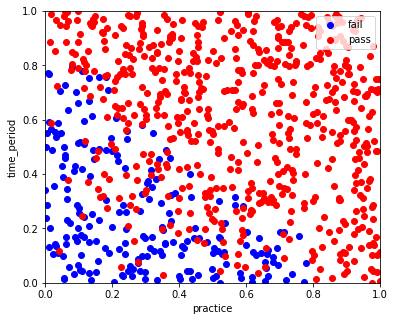

In [33]:
#区分好坏人
train_data = X_train.copy()
train_data['label'] = Y_train
practice_fail = train_data[train_data['label'] == 0]['practice']
time_period_fail = train_data[train_data['label']==0]['time_period']
practice_pass = train_data[train_data['label'] == 1]['practice']
time_period_pass = train_data[train_data['label']==1]['time_period']
#可视化作图
plt.figure(figsize=(6,5))
plt.xlim(0.0,1.0)
plt.ylim(0.0,1.0)
plt.scatter(practice_fail, time_period_fail, color = 'b', label='fail')
plt.scatter(practice_pass, time_period_pass, color = 'r', label='pass')
plt.xlabel('practice')
plt.ylabel('time_period')
plt.legend(loc='upper right')
plt.show()

## 训练Xgboost模型

Xgboost（eXtreme Gradient Boosting）是在GBDT（梯度下降决策树）算法基础上优化的一种集成模型，可以应用在分类和拟合的问题中，具有训练速度快、模型效果好、避免过拟合、自动处理缺失值、能处理大规模数据、支持多种编程语言等多个优点，在Kaggle社区和工业界得到广泛的关注。

本章重点数学知识：决策树、梯度下降、正则化

算法理论详见Xgboost官网：http://xgboost.readthedocs.io/en/latest/

D:\Anaconda\lib\site-packages\sklearn\preprocessing\label.py:95: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
D:\Anaconda\lib\site-packages\sklearn\preprocessing\label.py:128: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


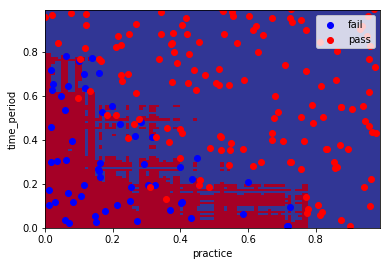

In [34]:
#Xgboost调参第0步：初始化
xgb0 = XGBClassifier(learning_rate=0.1,n_estimators=100,max_depth=5,min_child_weight=1,gamma=0,subsample=0.8,colsample_bytree=0.8,
                     objecttive='binary:logistic',seed=0)
xgb0.fit(X_train,Y_train,eval_metric='auc')
Y_test['pred'] = xgb0.predict_proba(X_test)[:,0]
plot_pic(xgb0,X_test,Y_test['label'])

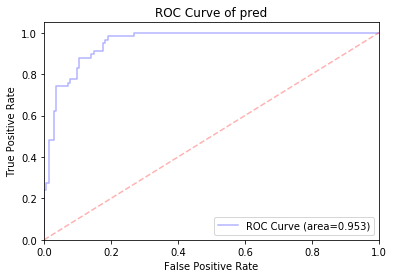

In [16]:
auc_fig = auc_calc(Y_test,['pred'],['label'])['auc_fig']
auc_fig

0.792617775619
0.139509916306


D:\Anaconda\lib\site-packages\ipykernel_launcher.py:8: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#ix-indexer-is-deprecated
  


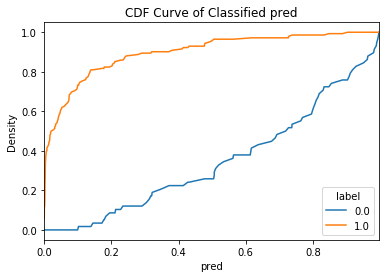

In [17]:
ks_dict = ks_calc(Y_test,['pred'],['label'])
print(ks_dict['ks'])
print(ks_dict['split'])
ks_dict['ks_fig']

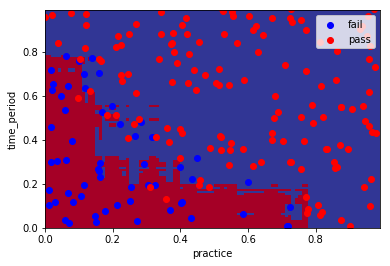

{'max_depth': 3, 'min_child_weight': 1}

In [36]:
#Xgboost调参第1步：调节max_depth和min_child_weight
param1 = {'max_depth':list(range(3,10,2)),'min_child_weight':list(range(1,6,2))}
xgb1 = GridSearchCV(estimator=XGBClassifier(learning_rate=0.1,n_estimators=100,gamma=0,subsample=0.8,colsample_bytree=0.8,
                    objecttive='binary:logistic',seed=0),param_grid=param1,scoring='roc_auc',cv=5)
xgb1.fit(X_train,Y_train.values.ravel())
Y_test['pred'] = xgb1.predict_proba(X_test)[:,0]
plot_pic(xgb1,X_test,Y_test['label'])
xgb1.best_params_

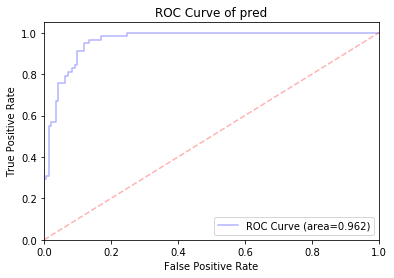

In [37]:
auc_fig = auc_calc(Y_test,['pred'],['label'])['auc_fig']
auc_fig

0.831714424478
0.224170446396


D:\Anaconda\lib\site-packages\ipykernel_launcher.py:8: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#ix-indexer-is-deprecated
  


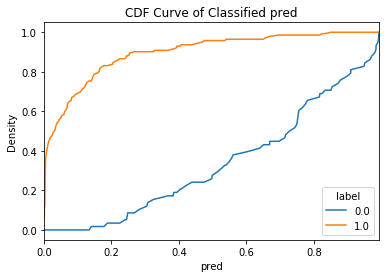

In [38]:
ks_dict = ks_calc(Y_test,['pred'],['label'])
print(ks_dict['ks'])
print(ks_dict['split'])
ks_dict['ks_fig']

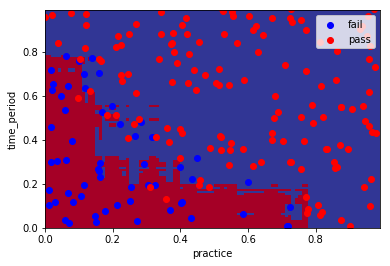

{'gamma': 0.0}

In [42]:
#Xgboost调参第2步：调节gamma
param2 = {'gamma':[i/10.0 for i in range(0,5)]}
xgb2 = GridSearchCV(estimator=XGBClassifier(learning_rate=0.1,n_estimators=100,max_depth=3,min_child_weight=1,subsample=0.8,colsample_bytree=0.8,
                     objecttive='binary:logistic',seed=0),param_grid=param2,scoring='roc_auc',cv=5)
xgb2.fit(X_train,Y_train.values.ravel())
Y_test['pred'] = xgb2.predict_proba(X_test)[:,0]
plot_pic(xgb2,X_test,Y_test['label'])
xgb2.best_params_

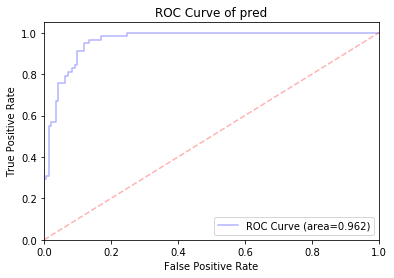

In [40]:
auc_fig = auc_calc(Y_test,['pred'],['label'])['auc_fig']
auc_fig

0.831714424478
0.224170446396


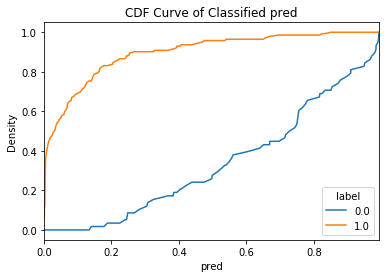

In [41]:
ks_dict = ks_calc(Y_test,['pred'],['label'])
print(ks_dict['ks'])
print(ks_dict['split'])
ks_dict['ks_fig']

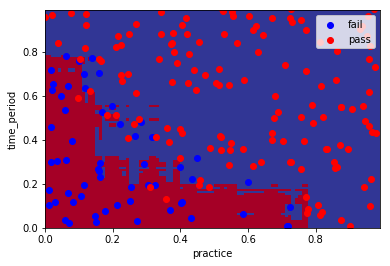

{'colsample_bytree': 0.5, 'subsample': 0.8}

In [46]:
#Xgboost调参第3步：调节subsample和colsample_bytree
param3 = {'subsample':[i/10.0 for i in range(5,10)],'colsample_bytree':[i/10.0 for i in range(5,10)]}
xgb3 = GridSearchCV(estimator=XGBClassifier(learning_rate=0.1,n_estimators=100,max_depth=3,min_child_weight=1,gamma=0,
                     objecttive='binary:logistic',seed=0),param_grid=param3,scoring='roc_auc',cv=5)
xgb3.fit(X_train,Y_train.values.ravel())
Y_test['pred'] = xgb3.predict_proba(X_test)[:,0]
plot_pic(xgb3,X_test,Y_test['label'])
xgb3.best_params_

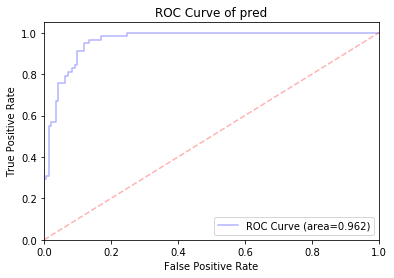

In [47]:
auc_fig = auc_calc(Y_test,['pred'],['label'])['auc_fig']
auc_fig

0.831714424478
0.224170446396


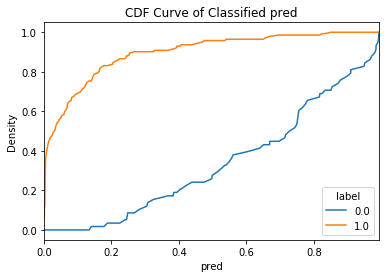

In [48]:
ks_dict = ks_calc(Y_test,['pred'],['label'])
print(ks_dict['ks'])
print(ks_dict['split'])
ks_dict['ks_fig']

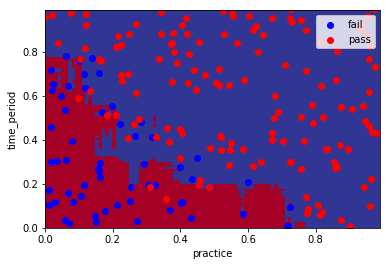

{'reg_alpha': 1}

In [51]:
#Xgboost调参第4步：调节regularization parameters
param4 = {'reg_alpha':[1e-5,1e-2,0.1,1,100]}
xgb4 = GridSearchCV(estimator=XGBClassifier(learning_rate=0.1,n_estimators=100,max_depth=3,min_child_weight=1,gamma=0,subsample=0.5,
                    colsample_bytree=0.8,objecttive='binary:logistic',seed=0),param_grid=param4,scoring='roc_auc',cv=5)
xgb4.fit(X_train,Y_train.values.ravel())
Y_test['pred'] = xgb4.predict_proba(X_test)[:,0]
plot_pic(xgb4,X_test,Y_test['label'])
xgb4.best_params_

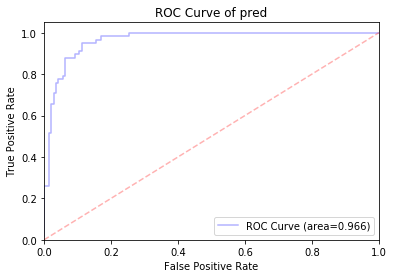

In [52]:
auc_fig = auc_calc(Y_test,['pred'],['label'])['auc_fig']
auc_fig

0.835599805731
0.25122243166


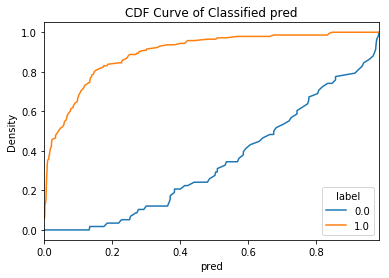

In [53]:
ks_dict = ks_calc(Y_test,['pred'],['label'])
print(ks_dict['ks'])
print(ks_dict['split'])
ks_dict['ks_fig']

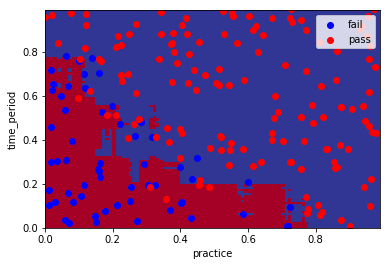

{'learning_rate': 0.1, 'n_estimators': 140}

In [54]:
#Xgboost调参第5步：调节learning_rate和n_estimators
param5 = {'learning_rate':[0.01,0.1,1],'n_estimators':[80,100,120,140]}
xgb5 = GridSearchCV(estimator=XGBClassifier(max_depth=3,min_child_weight=1,gamma=0,subsample=0.5,colsample_bytree=0.8,
                    reg_alpha=1,objecttive='binary:logistic',seed=0),param_grid=param5,scoring='roc_auc',cv=5)
xgb5.fit(X_train,Y_train.values.ravel())
Y_test['pred'] = xgb5.predict_proba(X_test)[:,0]
plot_pic(xgb5,X_test,Y_test['label'])
xgb5.best_params_

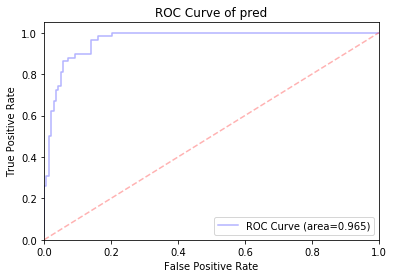

In [55]:
auc_fig = auc_calc(Y_test,['pred'],['label'])['auc_fig']
auc_fig

0.824672170957
0.222385287285


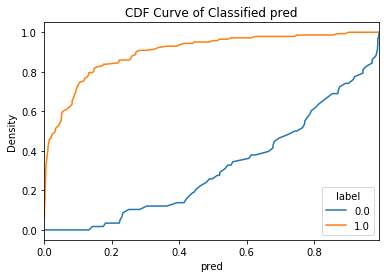

In [56]:
ks_dict = ks_calc(Y_test,['pred'],['label'])
print(ks_dict['ks'])
print(ks_dict['split'])
ks_dict['ks_fig']

D:\Anaconda\lib\site-packages\sklearn\preprocessing\label.py:95: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
D:\Anaconda\lib\site-packages\sklearn\preprocessing\label.py:128: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


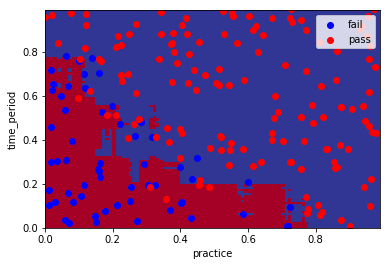

In [58]:
#训练最终Xgboost
xgb_clf = XGBClassifier(learning_rate=0.1,n_estimators=140,max_depth=3,min_child_weight=1,gamma=0,subsample=0.5,colsample_bytree=0.8,
            reg_alpha=1,objecttive='binary:logistic',seed=0)
xgb_clf.fit(X_train,Y_train,eval_metric='auc')
Y_test['pred'] = xgb_clf.predict_proba(X_test)[:,0]
plot_pic(xgb_clf,X_test,Y_test['label'])

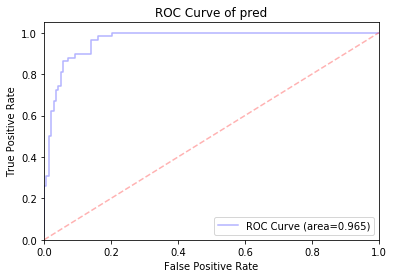

In [59]:
auc_fig = auc_calc(Y_test,['pred'],['label'])['auc_fig']
auc_fig

0.824672170957
0.222385287285


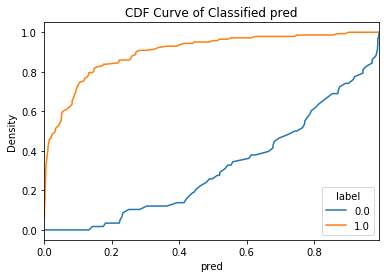

In [60]:
ks_dict = ks_calc(Y_test,['pred'],['label'])
print(ks_dict['ks'])
print(ks_dict['split'])
ks_dict['ks_fig']